# Calculate the central magnification of an eye - camera system

This notebook demonstrates how the `fundscale` module can be used to calculate the central magnification of an eye - camera system.

In [1]:
from dataclasses import dataclass

import sympy as sp

from PAROS import fundscale

sp.init_printing(use_unicode=True)

## Camera definition

Define the camera. The camera consists of a condenser lens and a focus lens. The condenser lens has a focal length of $f_{cond} = 0.027$ meters. The curvature of the focus lens is adjusted to create a focused image at the CCD, which is located at a distance of $f_{cond}$ from the condenser lens.
Additionally, a first order correction term $a_1$ is included. Both $f_{cond}$ and $a_1$ are calibrated using a phantom.

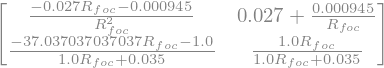

In [2]:
# define camera
camera_f_cond = 0.027
camera_a1 = 0.035

camera = fundscale.Camera(F_cond=camera_f_cond, a1=camera_a1)
camera_matrix = sp.simplify(camera.ray_transfer_matrix)
camera_matrix

## Eye model definition

Define the geometrical parameters of various eyes. The geometries are based on the Escudero-Sanz Navarro wide-field model.

In [3]:
phakic_geometry = {
    "R_corF": -7.72e-3,  # front corneal curvature
    "R_corB": -6.50e-3,  # rear corneal curvature
    "R_lensF": -10.20e-3,  # front lens curvature
    "R_lensB": +6.00e-3,  # rear lens curvature
    "D_cor": 0.55e-3,  # corneal thickness
    "D_ACD": 3.05e-3,  # anterior chamber depth
    "D_lens": 4.00e-3,  # lens thickness
    "D_vitr": 16.3203e-3,  # vitreous chamber depth
    "SE": 0,  # spherical equivalent of refraction
}

iol_thickness = 1e-3

iol_geometry = {
    "R_corF": -7.72e-3,
    "R_corB": -6.50e-3,
    "R_lensF": -8.16e-3,
    "R_lensB": +11.18e-3,
    "D_cor": 0.55e-3,
    "D_ACD": 3.05e-3,
    "D_lens": 1e-3,  # thickness of the IOL
    "D_vitr": 19.3203e-3,
    "SE": 0,
}

piol_geometry = {
    "R_corF": -7.72e-3,
    "R_corB": -6.50e-3,
    "R_lensF": -10.20e-3,
    "R_lensB": +6.00e-3,
    "D_cor": 0.55e-3,
    "D_ACD": 2.35e-3,
    "D_lens": 4.00e-3,
    "D_vitr": 13.5303e-3,
    "SE": 0,
}

# Definition of the pIOL
piol_data = fundscale.PhakicIOL(
    power=9,
    thickness=0.2e-3,
    refractive_index=1.47,
    lens_distance=0.5e-3,
)

Create eye models for the defined geometries, and fit the lens back surface to the specified spherical equivalent of refraction.

In [4]:
@dataclass
class MagnificationData:
    magnification: float = None
    lens_back_curvature: float = None
    glasses_curvature: float = None
    glasses_power: float = None
    eye_model: fundscale.Eye = None

    @classmethod
    def calculate_from_eye_model(cls, eye: fundscale.Eye, refraction: float):
        """Calculate magnification data from an eye model.

        Parameters
        ----------
        eye : fundScale.Eye
            Eye model.
        refraction : float
            Spherical equivalent of refraction of the eye.

        Returns
        -------
        MagnificationData
            Magnification data of the eye.
        """
        lens_back_curvature, glasses_curvature = eye.adjust_lens_back(
            refraction, update_model=True
        )
        magnification, glasses_power, _ = fundscale.calculate_magnification(
            phakic_eye, camera
        )

        return cls(
            magnification, lens_back_curvature, glasses_curvature, glasses_power, eye
        )

    def __str__(self):
        return (
            f"Magnification phakic eye model        : {abs(self.magnification):.2f}\n"
            f"Necessary correction at camera phakic : {self.glasses_power:.2f} D\n"
            f"Eye model                             : {self.eye_model}"
        )


# Define a phakic eye model
phakic_eye = fundscale.Eye(
    name="phakic",
    geometry=phakic_geometry,
    NType="Navarro",
    refraction=phakic_geometry["SE"],
)
phakic_magnification_data = MagnificationData()
# Fit the crystalline lens
(
    phakic_magnification_data.lens_back_curvature,
    phakic_magnification_data.glasses_curvature,
) = phakic_eye.adjust_lens_back(phakic_geometry["SE"], update_model=True)

# Define an eye model with an IOL
iol_eye = fundscale.Eye(
    name="IOL",
    geometry=iol_geometry,
    model_type="VughtIOL",
    NType="VughtIOL",
    refraction=iol_geometry["SE"],
)
iol_magnification_data = MagnificationData()
(
    iol_magnification_data.lens_back_curvature,
    iol_magnification_data.glasses_curvature,
) = iol_eye.adjust_lens_back(iol_geometry["SE"], update_model=True)

# Define an eye model with a phakic IOL
piol_eye = fundscale.Eye(
    name="pIOL",
    geometry=piol_geometry,
    NType="Navarro",
    refraction=piol_geometry["SE"],
    pIOL=piol_data,
)
piol_magnification_data = MagnificationData()
(
    piol_magnification_data.lens_back_curvature,
    piol_magnification_data.glasses_curvature,
) = piol_eye.adjust_lens_back(piol_geometry["SE"], update_model=True)

## Magnification calculation

Calculate the magnifications for the different eye models.

In [5]:
(
    phakic_magnification_data.magnification,
    phakic_magnification_data.glasses_power,
    phakic_magnification_data.eye_model,
) = fundscale.calculate_magnification(phakic_eye, camera)

print(phakic_magnification_data)

Magnification phakic eye model        : 1.64
Necessary correction at camera phakic : 0.00 D
Eye model                             : phakic


In [6]:
(
    iol_magnification_data.magnification,
    iol_magnification_data.glasses_power,
    iol_magnification_data.eye_model,
) = fundscale.calculate_magnification(iol_eye, camera)

print(iol_magnification_data)

Magnification phakic eye model        : 1.58
Necessary correction at camera phakic : 0.00 D
Eye model                             : IOL


In [7]:
(
    piol_magnification_data.magnification,
    piol_magnification_data.glasses_power,
    piol_magnification_data.eye_model,
) = fundscale.calculate_magnification(piol_eye, camera)

print(piol_magnification_data)

Magnification phakic eye model        : 1.91
Necessary correction at camera phakic : 0.00 D
Eye model                             : pIOL
